In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import import_ipynb
import Network_Jammed as Network

importing Jupyter notebook from Network_Jammed.ipynb


In [2]:
# calculates Poisson Ratio from shear and bulk moduli
def poisson_ratios(Gs, Bs):
    v = (1 - Gs/Bs) / (1 + Gs/Bs)
    return v

In [3]:
# returns the poisson ratios, mechanical failure mask (non-finite bulk modulus), adaptable training success mask, and adaptable training failure mask
def classify_adaptive(Bs, Gs, search_range, extremes):
    vs = poisson_ratios(Gs, Bs)
    
    mech_failures_mask = np.any(Bs < 1e-20, axis = 1)
    
    success_mask = np.logical_and(vs.T[search_range[0]] > extremes[0], vs.T[search_range[1]] < extremes[1]) & \
    np.logical_not(mech_failures_mask)
    
    fail_mask = np.logical_not(success_mask) & np.logical_not(mech_failures_mask)
    
    return vs, mech_failures_mask, success_mask, fail_mask

# returns the poisson ratios, mechanical failure mask (non-finite bulk modulus), control training success mask, and control training failure mask
def classify_control_up(Bs, Gs, timepoint, extreme):
    vs = poisson_ratios(Gs, Bs)
    mech_failures_mask = np.any(Bs < 1e-20, axis = 1)
    
    success_mask = (vs.T[timepoint] > extreme) & np.logical_not(mech_failures_mask)
    
    fail_mask = np.logical_not(success_mask) & np.logical_not(mech_failures_mask)
    
    return vs, mech_failures_mask, success_mask, fail_mask

# returns the poisson ratios, mechanical failure mask (non-finite bulk modulus), control training success mask, and control training failure mask
def classify_control_down(Bs, Gs, timepoint, extreme):
    vs = poisson_ratios(Gs, Bs)

    mech_failures_mask = np.any(Bs < 1e-20, axis = 1)
    
    success_mask = (vs.T[timepoint] < extreme) & np.logical_not(mech_failures_mask)
    
    fail_mask = np.logical_not(success_mask) & np.logical_not(mech_failures_mask)
    
    return vs, mech_failures_mask, success_mask, fail_mask

In [4]:
# given bulk and shear moduli and the classification function (adaptable, control up, or control down) with arguments, 
# plots the training trajectories with success, failure, and mechancal failure labels
def plot_trajectories(Bs, Gs, classification_func, *args):
    
    # classifies the training trajectories
    vs, mech_failures_mask, success_mask, fail_mask = classification_func(Bs, Gs, *args)
    
    matplotlib.rcParams.update({'font.size': 16})
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams["font.sans-serif"] = "Arial"

    success_count = 0
    fail_count = 0
    mech_fail_count = 0
    
    # plots each training trajectory with labeling
    for i in range(len(vs)):
        if success_mask[i] == True:
            if success_count == 0:
                plt.plot(vs[i], color = 'black', zorder = 2, label = 'Successes')
            else:
                plt.plot(vs[i], color = 'black', zorder = 2)
            success_count = success_count + 1

        elif fail_mask[i] == True:
            if fail_count == 0:
                plt.plot(vs[i], color = 'slategray', zorder = 1, label = 'Oscillating Training Failures')
            else:
                plt.plot(vs[i], color = 'slategray', zorder = 1)
            fail_count = fail_count + 1
        elif mech_failures_mask[i] == True:
            if mech_fail_count == 0:
                plt.plot(vs[i], color = 'lightgray', zorder = 0, label = 'Mechanical Failures')
            else:
                plt.plot(vs[i], color = 'lightgray', zorder = 0)
            mech_fail_count = mech_fail_count + 1

    plt.xlabel('bonds removed')
    plt.ylabel('$\\nu$')

    matplotlib.rcParams.update({'font.size': 12})
    plt.legend(loc = 0)
    plt.tight_layout()

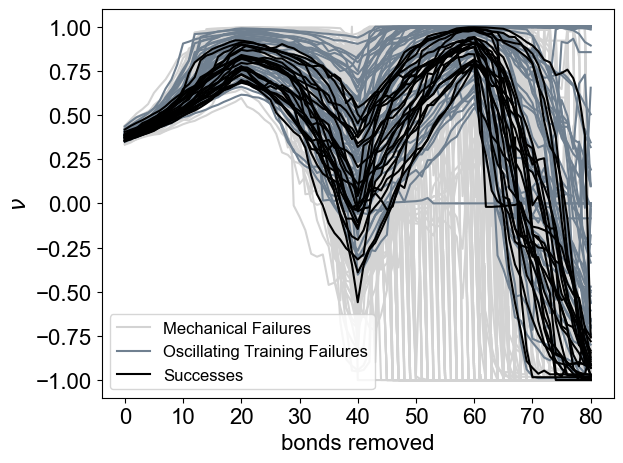

In [5]:
Bs = np.load('N200_20_4_Bs.npy')
Gs = np.load('N200_20_4_Gs.npy')
search_range = [60, 80]
extremes = [0.75, -0.75]

# classification and plotting of adaptive training trajectories
vs, mech_failures_mask, success_mask, fail_mask = classify_adaptive(Bs, Gs, search_range, extremes)
plot_trajectories(Bs, Gs, classify_adaptive, search_range, extremes)

In [6]:
def bond_differences(network1, network2):
    bond_ids = np.arange(len(network1.ks))[network1.ks != network2.ks]
    return bond_ids

In [7]:
def adaptive_vs_control_hist(N, cycle_length, num_cycles, adaptive_search_range, adaptive_extremes, \
                             timepoint_up, timepoint_down, control_extreme, random_times_up, random_times_down):
    
    # load in bulk and shear moduli for adaptive training and classify
    Bs_adapt = np.load('N' + str(N) + '_' + str(cycle_length) + '_' + str(num_cycles) + '_Bs.npy')
    Gs_adapt = np.load('N' + str(N) + '_' + str(cycle_length) + '_' + str(num_cycles) + '_Gs.npy')
    vs_adapt, mech_fail_adapt, success_adapt, fail_adapt = classify_adaptive(Bs_adapt, Gs_adapt, \
                                                                             adaptive_search_range, adaptive_extremes)
    # load in bulk and shear moduli for control training
    Bs_control_up = np.load('N' + str(N) + '_control_up_Bs.npy')
    Gs_control_up = np.load('N' + str(N) + '_control_up_Gs.npy')
    Bs_control_down = np.load('N' + str(N) + '_control_Bs.npy')
    Gs_control_down = np.load('N' + str(N) + '_control_Gs.npy')
    
    # classify control networks
    vs_up, mech_fail_up, success_up, fail_up = classify_control_up(Bs_control_up, Gs_control_up, timepoint_up, control_extreme)
    vs_down, mech_fail_down, success_down, fail_down = classify_control_down(Bs_control_down, Gs_control_down, timepoint_down, \
                                                                           -control_extreme)
    # filter the networks by successes
    plotable_adapt = np.arange(500)[success_adapt]
    plotable_control = np.arange(500)[success_up & success_down]
    total_control = []
    total_adapt = []

    # calculate bond differences between each pair of successfully adaptable networks
    for i in range(len(plotable_adapt)):
        adapt_net1 = Network.load('networks_for_histograms/adaptable_network_'+str(plotable_adapt[i])+'cycle_' + str(adaptive_search_range[0]))
        adapt_net2 = Network.load('networks_for_histograms/adaptable_network_'+str(plotable_adapt[i])+'cycle_' + str(adaptive_search_range[1]))
   
        diff_adapt = bond_differences(adapt_net1, adapt_net2)
        total_adapt.append(len(diff_adapt))
    
    # calculate bond differences between each pair of successful control networks
    for i in range(len(plotable_control)):
        control_net1 = Network.load('networks_for_histograms/control_network_'+str(plotable_control[i])+'cycle_' + str(random_times_down[i]))
        control_net2 = Network.load('networks_for_histograms/control_network_'+str(plotable_control[i])+'cycle_' + str(random_times_up[i]))

        diff_control = bond_differences(control_net1, control_net2)
        total_control.append(len(diff_control))
    
    matplotlib.rcParams.update({'font.size': 16})
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams["font.sans-serif"] = "Arial"
    
    
    # plot the histogram for adaptable (with oscillation) and control (no oscillation)
    bins = np.linspace(20, 100, 10)
    plt.hist(total_adapt, bins = bins, label = 'with oscillation', color = 'black')
    plt.hist(total_control, bins = bins, label = 'no oscillation', color = 'lightgray')
    
    plt.xlabel('bond differences')
    plt.ylabel('# of networks')
    
    matplotlib.rcParams.update({'font.size': 12})
    plt.legend(loc = 0)
    plt.tight_layout()

    return total_adapt, total_control, plotable_adapt, plotable_control

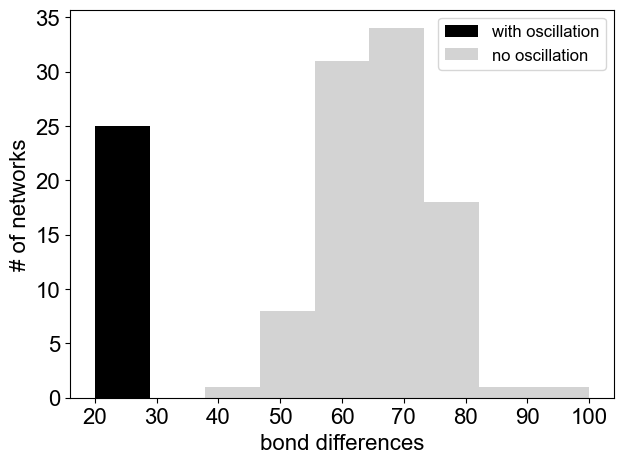

In [8]:
rt_down = np.load('random_times_down.npy')
rt_up = np.load('random_times_up.npy')
total_adapt, total_control, plotable_adapt, plotable_control = adaptive_vs_control_hist(200, 20, 4, [60, 80], [0.75, -0.75], \
                             80, 80, 0.75, rt_up, rt_down)